In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, BatchNormalization, Flatten, LSTM,Conv1D,MaxPooling1D
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Activation, Flatten, Input, concatenate, Conv1D, GlobalMaxPooling1D,SimpleRNN


In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link="https://drive.google.com/file/d/13DL3H3ShHMOuQo28TaxMsIiY59M8xMI8/view?usp=share_link"
id = link.split("/")[-2]
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Emotion_final.csv')
df = pd.read_csv('Emotion_final.csv')

In [ ]:
df.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [ ]:
df['Emotion'].value_counts()

happy       7029
sadness     6265
anger       2993
fear        2652
love        1641
surprise     879
Name: Emotion, dtype: int64

In [ ]:
df.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [ ]:
category = pd.get_dummies(df.Emotion)
df1 = pd.concat([df, category], axis=1)
df1 = df1.drop(columns='Emotion')

Data Preprocessing

In [ ]:
X = df1['Text'].values
y = df1[['happy', 'sadness', 'anger', 'fear', 'love', 'surprise']].values

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
tokenizer = Tokenizer(num_words = 5000, oov_token='<x>', filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

Seq_train = tokenizer.texts_to_sequences(X_train)
Seq_test = tokenizer.texts_to_sequences(X_test)

Pad_train = pad_sequences(Seq_train)
Pad_test = pad_sequences(Seq_test)

In [ ]:
vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")


Vocabulary size = 19260


**CNN-LSTM**

Model Building

In [ ]:
model = Sequential()
model.add(Embedding(input_dim = 5000, output_dim = 128)),
model.add(Conv1D(256,5,padding='valid',activation='relu',strides=1))
model.add(MaxPooling1D(pool_size=2))
model.add (BatchNormalization()),
model.add (Dropout(0.3)),
model.add(Conv1D(128, 5,padding='valid',activation='relu',strides=1))
model.add(MaxPooling1D(pool_size=2))
model.add (BatchNormalization()),
model.add (Dropout(0.3)),
model.add(LSTM(128))
model.add (Dropout(0.3)),
model.add(Dense(32))
model.add (Dropout(0.3)),
model.add(Dense(6))
model.add(Activation('softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         640000    
                                                                 
 conv1d (Conv1D)             (None, None, 256)         164096    
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 256)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, None, 256)        1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, None, 256)         0         
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         1

Model Training

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    Pad_train, y_train,
    epochs = 60,
    batch_size = 256,
    validation_data = (Pad_test, y_test),
    verbose = 1,
)

Epoch 1/60
68/68 [==============================] - 84s 1s/step - loss: 1.6496 - accuracy: 0.3080 - val_loss: 1.6186 - val_accuracy: 0.3029
Epoch 2/60
68/68 [==============================] - 61s 898ms/step - loss: 1.5787 - accuracy: 0.3519 - val_loss: 1.6414 - val_accuracy: 0.3029
Epoch 3/60
68/68 [==============================] - 66s 958ms/step - loss: 1.2811 - accuracy: 0.5110 - val_loss: 1.5109 - val_accuracy: 0.3239
Epoch 4/60
68/68 [==============================] - 62s 907ms/step - loss: 0.7477 - accuracy: 0.7328 - val_loss: 1.3597 - val_accuracy: 0.3889
Epoch 5/60
68/68 [==============================] - 62s 921ms/step - loss: 0.4857 - accuracy: 0.8288 - val_loss: 1.0962 - val_accuracy: 0.6377
Epoch 6/60
68/68 [==============================] - 63s 929ms/step - loss: 0.3812 - accuracy: 0.8624 - val_loss: 0.7493 - val_accuracy: 0.7169
Epoch 7/60
68/68 [==============================] - 65s 958ms/step - loss: 0.3050 - accuracy: 0.8894 - val_loss: 0.4932 - val_accuracy: 0.8339
Ep

Graph Plot

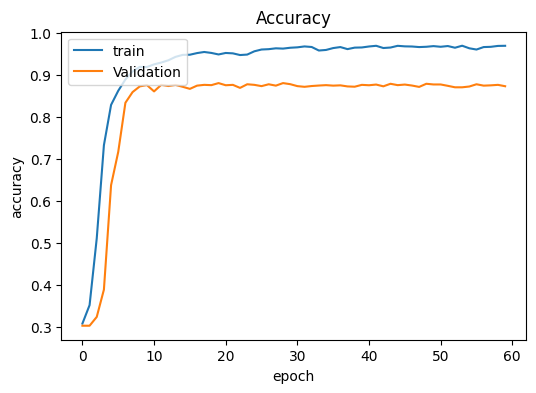

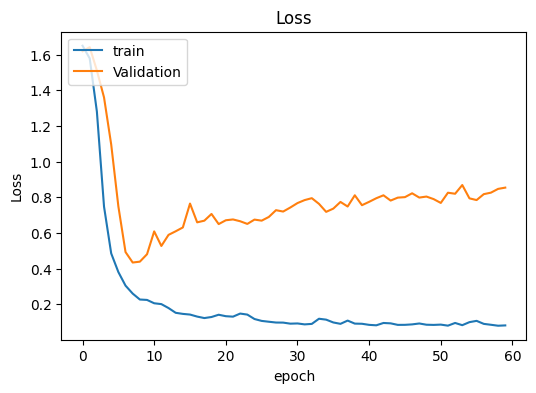

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()